In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import RobustScaler
import re
import warnings

# Suppress chained assignment warnings for cleaner output
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
RAW_DATA_PATH = Path("./raw_data/")
OFFSETS = [0, 1, 2, 3, 4]  # Augmentation offsets in minutes


def get_all_user_ids(data_path):
    """Scans the directory for HR files and extracts unique User IDs."""
    files = list(data_path.glob("HR_*.csv"))
    # Extract IDs (assuming format HR_xxxx.csv)
    ids = [
        re.search(r"HR_(\d+).csv", f.name).group(1)
        for f in files
        if re.search(r"HR_(\d+).csv", f.name)
    ]
    return sorted(list(set(ids)))


# --- HELPER FUNCTIONS ---


def process_hr_data(file_path):
    """Loads, Cleans, and Engineers HR Features."""
    # 1. Load & Sort
    df = pd.read_csv(file_path)
    df["HRTIME"] = pd.to_datetime(df["HRTIME"])
    df = df.sort_values("HRTIME")

    # 2. Clean (Drop NaNs, Filter Outliers 40-180bpm)
    df = df.dropna(subset=["HR"])
    df = df[(df["HR"] > 40) & (df["HR"] < 180)]

    # 3. Handle Duplicates (Mean of same second)
    df = df.groupby("HRTIME", as_index=False)["HR"].mean()
    df = df.sort_values("HRTIME")

    # 4. Calc Gaps for STV filtering
    df["time_gap_sec"] = df["HRTIME"].diff().dt.total_seconds()

    # 5. Feature Engineering (Rolling Windows)
    df = df.set_index("HRTIME").sort_index()

    # Mean & Volatility
    df["mean_hr_5min"] = df["HR"].rolling("5min", min_periods=30).mean()
    df["hr_volatility_5min"] = df["HR"].rolling("5min", min_periods=30).std()

    # STV / Jumpiness
    df["hr_diff"] = df["HR"].diff().abs()
    mask_valid_diff = df["time_gap_sec"] <= 5  # Only diff if gap < 5s
    df.loc[~mask_valid_diff, "hr_diff"] = np.nan

    df["hr_jumpiness_5min"] = np.sqrt((df["hr_diff"] ** 2).rolling("5min", min_periods=30).mean())

    # Coefficient of Variation
    df["stress_cv"] = df["hr_volatility_5min"] / (df["mean_hr_5min"] + 0.1)

    # 6. Final Clean & Scale
    # Drop bad dates (Year 2000 bug) and warm-up NaNs
    df = df[df.index.year > 2021].copy()
    df = df.dropna(subset=["mean_hr_5min", "hr_jumpiness_5min"])

    if df.empty:
        return None

    # Log Transform & Scale
    cols_to_log = ["hr_volatility_5min", "hr_jumpiness_5min"]
    df[cols_to_log] = np.log1p(df[cols_to_log])

    scaler = RobustScaler()
    cols_scale = ["mean_hr_5min", "hr_volatility_5min", "hr_jumpiness_5min", "stress_cv"]
    df[cols_scale] = scaler.fit_transform(df[cols_scale])

    return df.reset_index()  # Return with HRTIME as column


def process_pvt_data(file_path):
    """Loads and Aggregates PVT Data."""
    df = pd.read_csv(file_path)
    df["TESTSTART"] = pd.to_datetime(df["TESTSTART"])

    # Filter Artifacts (False starts < 100ms)
    valid_pvt = df[df["TAPTIME"] > 100].copy()

    # Aggregate per Test
    pvt_targets = valid_pvt.groupby(["TESTID", "TESTSTART"]).agg({"TAPTIME": "mean"}).reset_index()
    pvt_targets.rename(columns={"TAPTIME": "pvt_mean_rt"}, inplace=True)
    return pvt_targets


def process_sleep_data(file_path):
    """Loads and Calculates Sleep Debt."""
    df = pd.read_csv(file_path)
    df["START"] = pd.to_datetime(df["START"])
    df["END"] = pd.to_datetime(df["END"])

    # Clean Duplicates
    df = df.drop_duplicates(subset=["START", "END"])

    # Calculate Duration & Filter Outliers (15 mins to 36 hours)
    df["duration_hours"] = (df["END"] - df["START"]).dt.total_seconds() / 3600
    df = df[(df["duration_hours"] > 0.25) & (df["duration_hours"] < 36)]
    df = df.sort_values("END")

    # Rolling Debt Logic
    df["sleep_debt"] = 8.0 - df["duration_hours"]

    # Rolling sum over last 3 records
    # Group by a dummy key because this function runs per-user
    df["_temp_group"] = 1
    df["cum_sleep_debt"] = (
        df.groupby("_temp_group")["sleep_debt"]
        .rolling(3, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )

    return df[["START", "END", "duration_hours", "cum_sleep_debt"]]


# --- MAIN AGGREGATION LOOP ---

all_user_data = []
user_ids = get_all_user_ids(RAW_DATA_PATH)
print(f"Found {len(user_ids)} users: {user_ids}")

for uid in user_ids:
    print(f"\nProcessing User {uid}...", end=" ")

    # Define File Paths
    hr_file = RAW_DATA_PATH / f"HR_{uid}.csv"
    pvt_file = RAW_DATA_PATH / f"pvt_{uid}.csv"
    sleep_file = RAW_DATA_PATH / f"sleep_{uid}.csv"

    # Check if files exist
    if not (hr_file.exists() and pvt_file.exists() and sleep_file.exists()):
        print("Skipped (Missing required files).")
        continue

    try:
        # 1. Process Individual Datasets
        df_hr = process_hr_data(hr_file)
        if df_hr is None:
            print("Skipped (No valid HR data).")
            continue

        df_pvt = process_pvt_data(pvt_file)
        df_sleep = process_sleep_data(sleep_file)

        # 2. Augmentation & HR Merge
        augmented_dfs = []
        for offset in OFFSETS:
            # Shift Target Time
            targets_shifted = df_pvt.copy()
            targets_shifted["MATCH_TIME"] = targets_shifted["TESTSTART"] - pd.Timedelta(
                minutes=offset
            )

            # Merge with HR (Backward look)
            merged = pd.merge_asof(
                targets_shifted.sort_values("MATCH_TIME"),
                df_hr.sort_values("HRTIME"),
                left_on="MATCH_TIME",
                right_on="HRTIME",
                direction="backward",
                tolerance=pd.Timedelta("10 minutes"),
            )
            merged["aug_offset"] = offset
            augmented_dfs.append(merged)

        df_aug = pd.concat(augmented_dfs, ignore_index=True)
        # Drop rows where HR merge failed (sensor off)
        df_aug = df_aug.dropna(subset=["mean_hr_5min", "hr_jumpiness_5min"])

        if df_aug.empty:
            print("Skipped (No overlapping HR and PVT data).")
            continue

        # 3. Merge with Sleep
        # Rename for merge
        df_sleep_merge = df_sleep.rename(columns={"END": "last_sleep_end"})

        # Merge Sleep (Backward look)
        df_final_user = pd.merge_asof(
            df_aug.sort_values("TESTSTART"),
            df_sleep_merge.sort_values("last_sleep_end"),
            left_on="TESTSTART",
            right_on="last_sleep_end",
            direction="backward",
        )

        # 4. Final Feature Engineering (Context)
        # Hours Awake & Inertia
        df_final_user["hours_awake"] = (
            df_final_user["TESTSTART"] - df_final_user["last_sleep_end"]
        ).dt.total_seconds() / 3600
        df_final_user["sleep_inertia_idx"] = 1 / (df_final_user["hours_awake"] + 0.1)

        # Circadian Rhythm
        test_hour = df_final_user["TESTSTART"].dt.hour + (df_final_user["TESTSTART"].dt.minute / 60)
        df_final_user["circadian_sin"] = np.sin(2 * np.pi * test_hour / 24)
        df_final_user["circadian_cos"] = np.cos(2 * np.pi * test_hour / 24)

        # Drop rows with no sleep history found
        df_final_user = df_final_user.dropna(subset=["hours_awake"])

        # Add User ID column (Crucial for GroupKFold validation later)
        df_final_user["user_id"] = uid

        print(f"Done. Added {len(df_final_user)} rows.")
        all_user_data.append(df_final_user)

    except Exception as e:
        print(f"Error: {e}")

# --- FINAL AGGREGATION ---
if all_user_data:
    df_total = pd.concat(all_user_data, ignore_index=True)
    print("\n" + "=" * 40)
    print("AGGREGATION COMPLETE")
    print(f"Total Unique Users: {df_total['user_id'].nunique()}")
    print(f"Total Training Rows: {len(df_total)}")
    print("=" * 40)

    # Save the aggregated file
    df_total.to_csv("./cleaned_data/training_data_all_users.csv", index=False)

    # Preview
    cols = ["user_id", "TESTSTART", "pvt_mean_rt", "mean_hr_5min", "hours_awake", "cum_sleep_debt"]
    print(df_total[cols].head())
else:
    print("No valid data generated. Check your /raw_data/ folder path.")

Found 0 users: []
No valid data generated. Check your /raw_data/ folder path.


Sanity Check

Biology Check: Does hours_awake positively correlate with pvt_mean_rt (Reaction Time)? If it's negative, your calculation might be wrong (e.g., measuring "time until sleep" instead of "time since wake").

Multicollinearity: If hr_volatility_5min and stress_cv have a 0.99 correlation, you are feeding the model duplicate information. Trees (Random Forest/Gradient Boosting) handle this well, but it wastes computation.

Feature Importance Preview: If mean_hr_5min has a 0.01 correlation with fatigue, the model will struggle to use it.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./cleaned_data/training_data_all_users.csv")

# --- 1. Correlation Matrix ---
# Select only numeric feature columns + target
cols_to_check = [
    "pvt_mean_rt",  # Target
    "mean_hr_5min",
    "hr_volatility_5min",
    "hr_jumpiness_5min",
    "stress_cv",  # Physiology
    "hours_awake",
    "cum_sleep_debt",
    "circadian_sin",
    "circadian_cos",  # Context
]

corr = df[cols_to_check].corr()

# --- 2. Visualization: Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

# --- 3. The "Predictive Power" Check ---
# What correlates most with Reaction Time?
print("--- Correlation with Fatigue (Target) ---")
print(corr["pvt_mean_rt"].sort_values(ascending=False))

ModuleNotFoundError: No module named 'seaborn'

The Pipeline Strategy
Data Splitting (Group-Aware): We use GroupShuffleSplit. This guarantees that all 5 augmented copies of a specific test stay together. We never let the model see "Test A (Copy 1)" in training and "Test A (Copy 2)" in testing.

Hyperparameter Tuning: We use GridSearchCV to find the best learning rate and depth.

Visualization: We implement "Staged Prediction" to visualize the model learning over time.

Training Grid Search on: 1036 samples
Final Test Holdout:      265 samples

Running Grid Search with 5-Fold CV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100, 'subsample': 0.8}
BEST CV RMSE: 66.40 ms



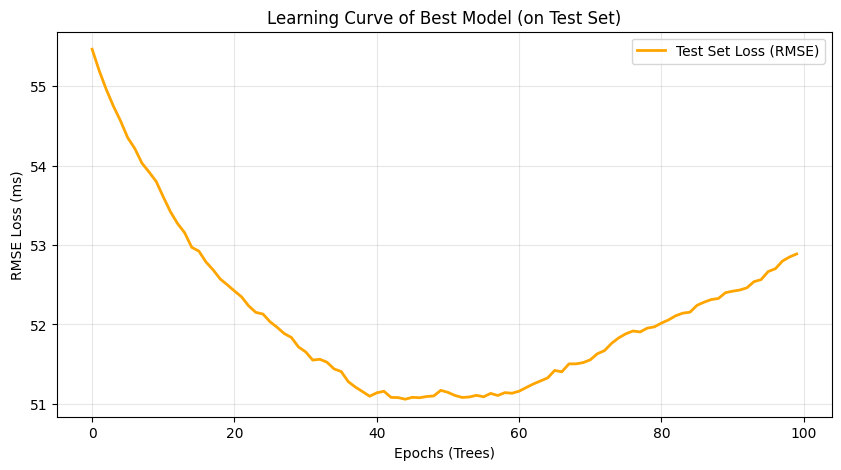

------------------------------
FINAL TEST SET RESULTS
------------------------------
RMSE: 52.89 ms
R²:   0.10


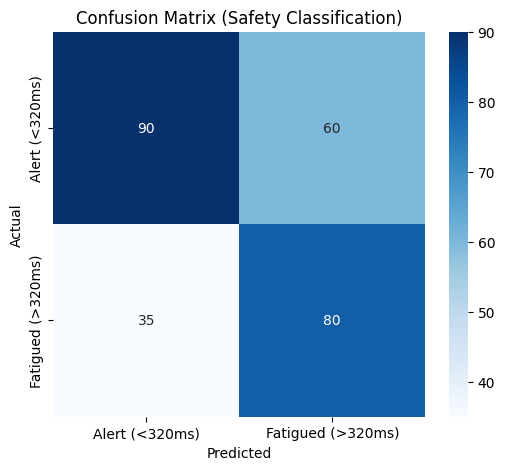


Classification Report:

                   precision    recall  f1-score   support

   Alert (<320ms)       0.72      0.60      0.65       150
Fatigued (>320ms)       0.57      0.70      0.63       115

         accuracy                           0.64       265
        macro avg       0.65      0.65      0.64       265
     weighted avg       0.66      0.64      0.64       265



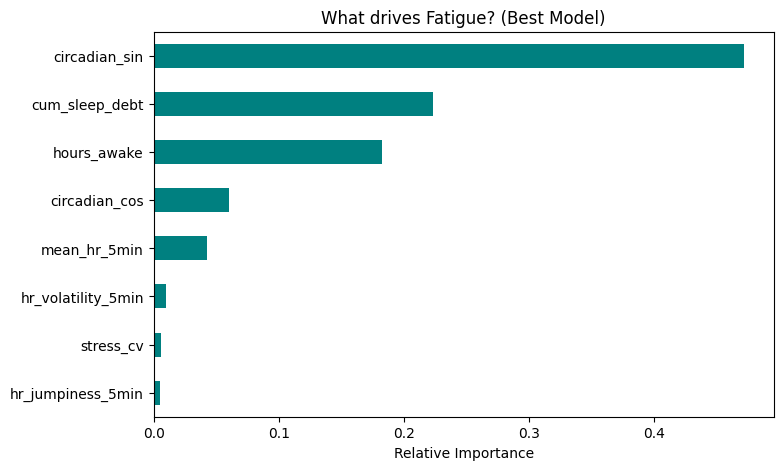

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

# --- 1. SETUP ---
# df = pd.read_csv("./cleaned_data/training_data_all_users.csv") # Load your data
features = [
    "mean_hr_5min",
    "hr_volatility_5min",
    "hr_jumpiness_5min",
    "stress_cv",
    "hours_awake",
    "cum_sleep_debt",
    "circadian_sin",
    "circadian_cos",
]
target = "pvt_mean_rt"

X = df[features]
y = df[target]
# Ensure groups are robust (User + Specific Test session)
groups = df["user_id"].astype(str) + "_" + df["TESTSTART"].astype(str)

# --- 2. SPLIT DATA (TRAIN / TEST) ---
# We ONLY do one split here: Hold out 20% for the Final Honest Test.
# The Cross-Validation (CV) will handle the internal Training/Validation splits automatically.
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter_test.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

print(f"Training Grid Search on: {len(X_train)} samples")
print(f"Final Test Holdout:      {len(X_test)} samples")

# --- 3. DEFINE HYPERPARAMETER GRID ---
# Define the dictionary of parameters you want to test
param_grid = {
    "n_estimators": [100, 300, 500],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1],  # Step size
    "max_depth": [3, 4, 5],  # Tree complexity
    "subsample": [0.8, 1.0],  # Fraction of data used per tree
    "min_samples_leaf": [1, 5],  # Prevents overfitting on noise
}

# Initialize the base model (you can set fixed params here like random_state)
gbm = GradientBoostingRegressor(random_state=42)

# --- 4. SETUP CROSS-VALIDATION SEARCH ---
# Critical: Use GroupKFold so splits obey user sessions
gkf = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=gkf,
    scoring="neg_root_mean_squared_error",  # Sklearn optimizes for "higher is better", so it uses negative RMSE
    n_jobs=-1,  # Use all CPU cores
    verbose=1,
)

# --- 5. TRAIN (FIT) ---
print("\nRunning Grid Search with 5-Fold CV...")
# Important: Pass groups to fit so CV knows how to split safely!
grid_search.fit(X_train, y_train, groups=groups_train)

# Get the winner
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive RMSE

print("\n" + "=" * 40)
print(f"BEST PARAMS: {best_params}")
print(f"BEST CV RMSE: {best_score:.2f} ms")
print("=" * 40 + "\n")

# --- 6. VISUALIZATION (Optional Check) ---
# Note: Since CV trains 5 times, we don't have a single "loss curve" for the whole process.
# However, we can check how the WINNING model performs on the TEST set over time
# to ensure it has converged.

test_loss = []
# Calculate RMSE on the Test set for every tree added
for y_pred in best_model.staged_predict(X_test):
    mse = mean_squared_error(y_test, y_pred)
    test_loss.append(np.sqrt(mse))

plt.figure(figsize=(10, 5))
plt.plot(test_loss, label="Test Set Loss (RMSE)", linewidth=2, color="orange")
plt.xlabel("Epochs (Trees)")
plt.ylabel("RMSE Loss (ms)")
plt.title("Learning Curve of Best Model (on Test Set)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- 7. FINAL EVALUATION ON TEST SET ---
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)
r2_test = r2_score(y_test, y_pred_test)

print("-" * 30)
print("FINAL TEST SET RESULTS")
print("-" * 30)
print(f"RMSE: {rmse_test:.2f} ms")
print(f"R²:   {r2_test:.2f}")

# --- 8. FEATURE IMPORTANCE ---
plt.figure(figsize=(8, 5))
imp = pd.Series(best_model.feature_importances_, index=features).sort_values()
imp.plot(kind="barh", color="teal")
plt.title("What drives Fatigue? (Best Model)")
plt.xlabel("Relative Importance")
plt.show()

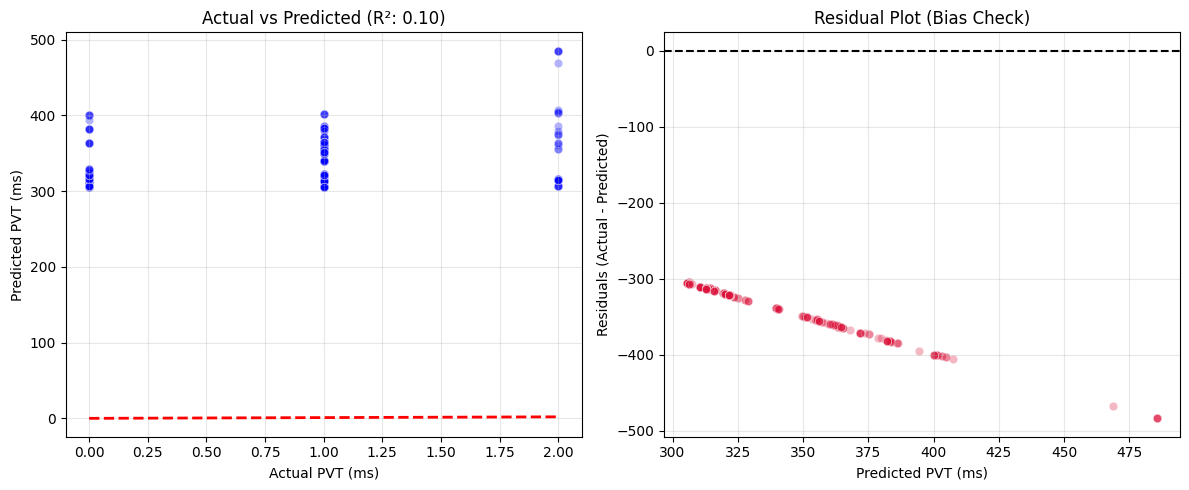

In [60]:
# --- 9. VISUAL DIAGNOSTICS ---
plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted (The Truth Check)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3, color="blue")
# Draw the perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual PVT (ms)")
plt.ylabel("Predicted PVT (ms)")
plt.title(f"Actual vs Predicted (R²: {r2_test:.2f})")
plt.grid(True, alpha=0.3)

# Plot 2: Residual Plot (Where are the errors?)
residuals = y_test - y_pred_test
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.3, color="crimson")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted PVT (ms)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Bias Check)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Retraining with best params for visualization: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100, 'subsample': 0.8}


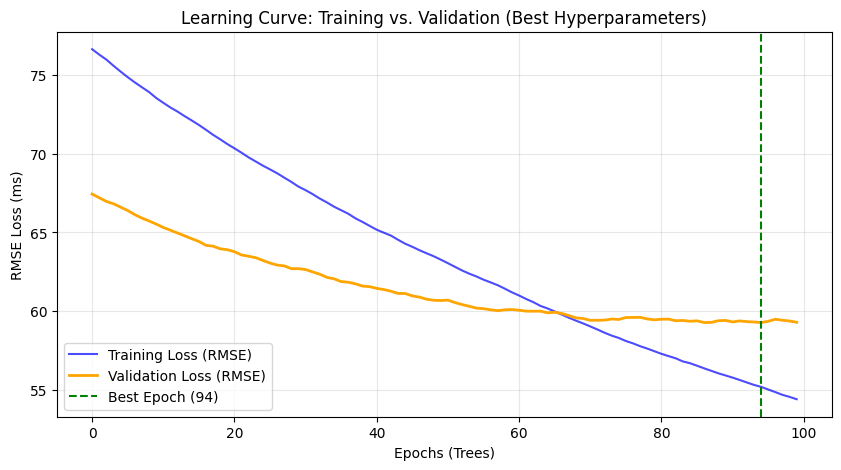

In [56]:
# --- 6. VISUALIZATION: Re-train Best Model for Plotting ---

# 1. Get the best parameters found by Grid Search
params = grid_search.best_params_
print(f"Retraining with best params for visualization: {params}")

# 2. Create a temporary Train/Validation split just for this plot
#    (We need a validation set to draw the orange line)
splitter_viz = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_viz_idx, val_viz_idx = next(splitter_viz.split(X_train, y_train, groups=groups_train))

X_train_viz, X_val_viz = X_train.iloc[train_viz_idx], X_train.iloc[val_viz_idx]
y_train_viz, y_val_viz = y_train.iloc[train_viz_idx], y_train.iloc[val_viz_idx]

# 3. Initialize model with the BEST parameters
viz_model = GradientBoostingRegressor(
    **params,  # Unpack the best parameters here
    random_state=42,
)

# 4. Fit the model
viz_model.fit(X_train_viz, y_train_viz)

# 5. Calculate Loss per Epoch (Tree)
train_loss = []
val_loss = []

# Get Training Error
for y_pred_train in viz_model.staged_predict(X_train_viz):
    train_loss.append(np.sqrt(mean_squared_error(y_train_viz, y_pred_train)))

# Get Validation Error
for y_pred_val in viz_model.staged_predict(X_val_viz):
    val_loss.append(np.sqrt(mean_squared_error(y_val_viz, y_pred_val)))

# 6. Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Training Loss (RMSE)", alpha=0.7, color="blue")
plt.plot(val_loss, label="Validation Loss (RMSE)", linewidth=2, color="orange")

# Find the lowest validation error point
best_epoch = np.argmin(val_loss)
plt.axvline(x=best_epoch, color="green", linestyle="--", label=f"Best Epoch ({best_epoch})")

plt.xlabel("Epochs (Trees)")
plt.ylabel("RMSE Loss (ms)")
plt.title("Learning Curve: Training vs. Validation (Best Hyperparameters)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

normalize pvt


Training Context-Aware Model...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

FINAL HYBRID RESULTS
RMSE: 58.26 ms
R²:   -0.10 (Targeting > 0.15)


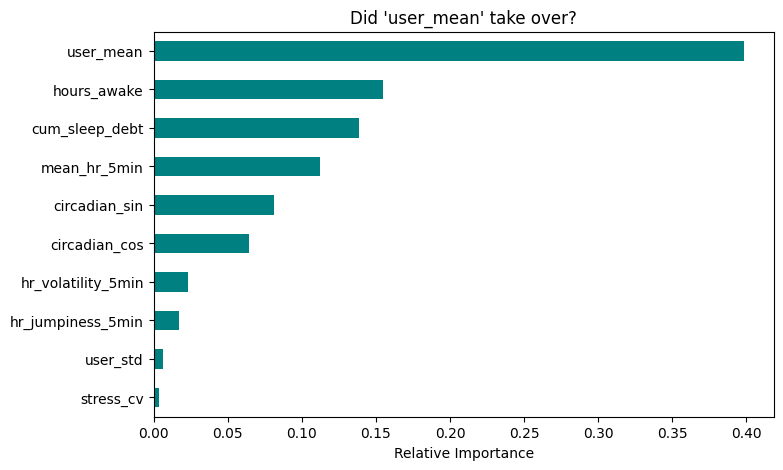

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. SETUP ---
df = pd.read_csv("./cleaned_data/training_data_all_users.csv")  # Load data

# A. Calculate User Baselines
user_stats = df.groupby("user_id")["pvt_mean_rt"].agg(["mean", "std"]).reset_index()
user_stats.rename(columns={"mean": "user_mean", "std": "user_std"}, inplace=True)
df = df.merge(user_stats, on="user_id", how="left")
# Fill NaNs for users with only 1 record
df["user_std"] = df["user_std"].fillna(0)

# B. UPDATE FEATURES LIST (Add the context!)
features = [
    "mean_hr_5min",
    "hr_volatility_5min",
    "hr_jumpiness_5min",
    "stress_cv",
    "hours_awake",
    "cum_sleep_debt",
    "circadian_sin",
    "circadian_cos",
    "user_mean",  # <--- NEW: Tell the model the user's baseline speed
    "user_std",  # <--- NEW: Tell the model how erratic the user usually is
]

target = "pvt_mean_rt"  # <--- Back to Raw MS

X = df[features]
y = df[target]
groups = df["user_id"].astype(str) + "_" + df["TESTSTART"].astype(str)

# --- 2. SPLIT & TRAIN (Standard process) ---
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter_test.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

# Define Grid
param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4],
    "subsample": [0.8],
}

gbm = GradientBoostingRegressor(random_state=42)
gkf = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=gkf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

print("\nTraining Context-Aware Model...")
grid_search.fit(X_train, y_train, groups=groups_train)
best_model = grid_search.best_estimator_

# --- 3. RESULTS ---
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "=" * 40)
print("FINAL HYBRID RESULTS")
print("=" * 40)
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.2f} (Targeting > 0.15)")

# --- 4. FEATURE IMPORTANCE ---
plt.figure(figsize=(8, 5))
imp = pd.Series(best_model.feature_importances_, index=features).sort_values()
imp.plot(kind="barh", color="teal")
plt.title("Did 'user_mean' take over?")
plt.xlabel("Relative Importance")
plt.show()

classification

In [166]:
# --- 1. SETUP & RE-GROUPING ---
df = pd.read_csv("./cleaned_data/training_data_all_users.csv")  # Load data


# Define your 3 classes
# 0: Alert (<300ms) | 1: Groggy (300-400ms) | 2: Fatigued (>400ms)
def create_classes(rt):
    if rt < 330:
        return 0
    else:
        return 1


# Apply to your target
df["fatigue_binary"] = df["pvt_mean_rt"].apply(create_classes)

# A. Calculate User Baselines
user_stats = df.groupby("user_id")["pvt_mean_rt"].agg(["mean", "std"]).reset_index()
user_stats.rename(columns={"mean": "user_mean", "std": "user_std"}, inplace=True)
df = df.merge(user_stats, on="user_id", how="left")
# Fill NaNs for users with only 1 record
df["user_std"] = df["user_std"].fillna(0)

# B. UPDATE FEATURES LIST (Add the context!)
features = [
    "mean_hr_5min",
    "hr_volatility_5min",
    "hr_jumpiness_5min",
    "stress_cv",
    "hours_awake",
    "cum_sleep_debt",
    "circadian_sin",
    "circadian_cos",
    "user_mean",  # <--- NEW: Tell the model the user's baseline speed
    "user_std",  # <--- NEW: Tell the model how erratic the user usually is
]

X = df[features]
y = df["fatigue_binary"]  # New Target!
groups = df["user_id"].astype(str) + "_" + df["TESTSTART"].astype(str)

# Check imbalance (You likely have way more Class 1 than Class 2)
print("Class Counts:\n", y.value_counts())

Class Counts:
 fatigue_binary
0    811
1    490
Name: count, dtype: int64


Training on 1036 samples. Testing on 265 samples.

Running Grid Search for Binary Model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score: 0.68


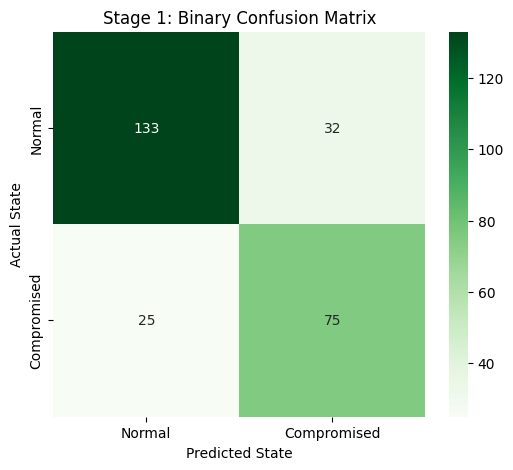


Classification Report (Binary):
              precision    recall  f1-score   support

      Normal       0.84      0.81      0.82       165
 Compromised       0.70      0.75      0.72       100

    accuracy                           0.78       265
   macro avg       0.77      0.78      0.77       265
weighted avg       0.79      0.78      0.79       265



In [121]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold

# --- 2. TRAIN BINARY MODEL ---
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter_test.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

print(f"Training on {len(X_train)} samples. Testing on {len(X_test)} samples.")

# --- 2. STAGE 1: FINE-TUNE BINARY MODEL (GRID SEARCH) ---
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
}

gbc = GradientBoostingClassifier(random_state=42)
gkf = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=gkf,
    scoring="recall",  # Optimize for balance between classes
    n_jobs=-1,
    verbose=1,
)

print("\nRunning Grid Search for Binary Model...")
grid_search.fit(X_train, y_train, groups=groups_train)

best_model = grid_search.best_estimator_
print(f"\nBest Params: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.2f}")

# --- 3. EVALUATE STAGE 1 (CONFUSION MATRIX) ---
y_pred_binary = best_model.predict(X_test)

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
labels = ["Normal", "Compromised"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Stage 1: Binary Confusion Matrix")
plt.ylabel("Actual State")
plt.xlabel("Predicted State")
plt.show()

print("\nClassification Report (Binary):")
print(classification_report(y_test, y_pred_binary, target_names=labels))


--- SAMPLE ALERTS (Stage 2 Output) ---
     Actual_Binary  Predicted_Binary  Risk_Probability  \
20               1                 1          0.736656   
173              0                 1          0.976872   
60               0                 0          0.046115   
196              0                 0          0.011323   
22               1                 0          0.262843   
4                0                 0          0.048327   
225              0                 0          0.006344   
170              0                 1          0.976872   
257              0                 0          0.024261   
3                0                 0          0.052907   

                   Final_Alert  
20   RED: FATIGUE (Risk: 0.74)  
173  RED: FATIGUE (Risk: 0.98)  
60               Green: Normal  
196              Green: Normal  
22               Green: Normal  
4                Green: Normal  
225              Green: Normal  
170  RED: FATIGUE (Risk: 0.98)  
257              Green: 

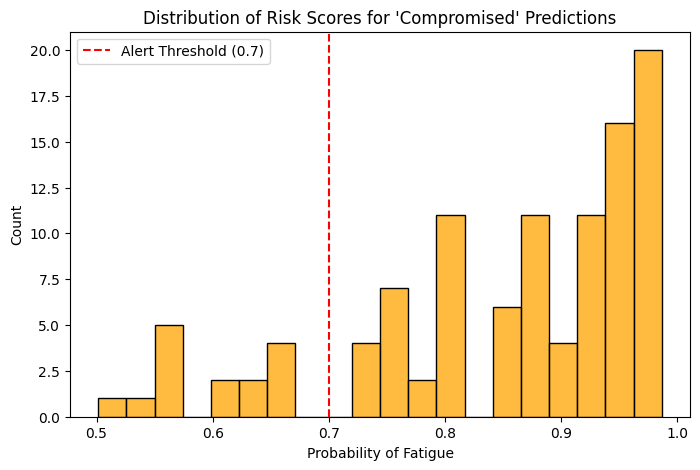

In [122]:
# --- 4. STAGE 2: PROBABILITY-BASED ALERTS ---
# Get the probability that the user is Compromised (Class 1)
y_prob_compromised = best_model.predict_proba(X_test)[:, 1]

# Define Alert Logic
# If Prob > 0.70 --> High Confidence --> "Fatigued" (Red)
# If Prob < 0.70 --> Low Confidence  --> "Groggy" (Yellow)
FATIGUE_CONFIDENCE_THRESHOLD = 0.70

final_alerts = []
risk_scores = []

for pred_class, prob in zip(y_pred_binary, y_prob_compromised):
    if pred_class == 0:
        final_alerts.append("Green: Normal")
        risk_scores.append(0)  # Logic: 0 risk
    else:
        # It is Compromised (Class 1). Check severity.
        if prob >= FATIGUE_CONFIDENCE_THRESHOLD:
            final_alerts.append(f"RED: FATIGUE (Risk: {prob:.2f})")
            risk_scores.append(2)
        else:
            final_alerts.append(f"Yellow: Groggy (Risk: {prob:.2f})")
            risk_scores.append(1)

# Display a sample of the results
results_df = pd.DataFrame(
    {
        "Actual_Binary": y_test.values,
        "Predicted_Binary": y_pred_binary,
        "Risk_Probability": y_prob_compromised,
        "Final_Alert": final_alerts,
    }
)

print("\n--- SAMPLE ALERTS (Stage 2 Output) ---")
print(results_df.sample(10))

# Optional: Visualize the Split
plt.figure(figsize=(8, 5))
sns.histplot(
    data=results_df[results_df["Predicted_Binary"] == 1],
    x="Risk_Probability",
    bins=20,
    color="orange",
)
plt.axvline(
    FATIGUE_CONFIDENCE_THRESHOLD,
    color="red",
    linestyle="--",
    label=f"Alert Threshold ({FATIGUE_CONFIDENCE_THRESHOLD})",
)
plt.title("Distribution of Risk Scores for 'Compromised' Predictions")
plt.xlabel("Probability of Fatigue")
plt.legend()
plt.show()

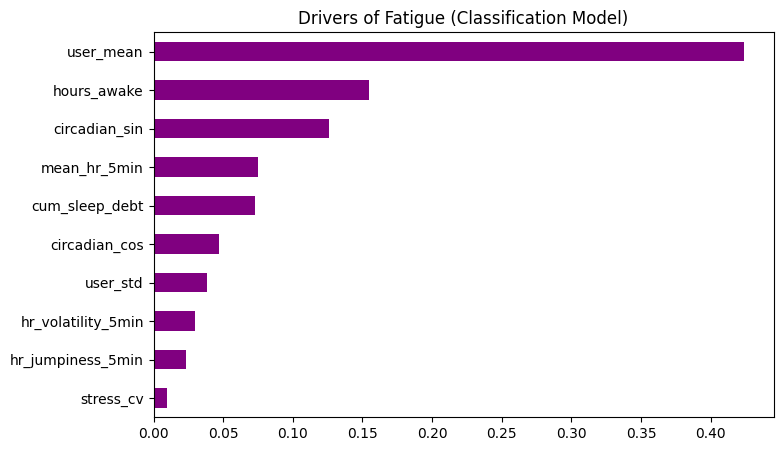

In [123]:
# Check Feature Importance for the Classifier
plt.figure(figsize=(8, 5))
imp = pd.Series(best_model.feature_importances_, index=features).sort_values()
imp.plot(kind="barh", color="purple")
plt.title("Drivers of Fatigue (Classification Model)")
plt.show()

Training on 1036 samples. Testing on 265 samples.

TRAINING RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 25, 'n_estimators': 100}


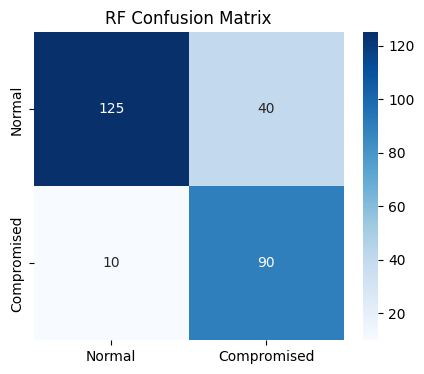

              precision    recall  f1-score   support

      Normal       0.93      0.76      0.83       165
 Compromised       0.69      0.90      0.78       100

    accuracy                           0.81       265
   macro avg       0.81      0.83      0.81       265
weighted avg       0.84      0.81      0.81       265



In [167]:
from sklearn.ensemble import RandomForestClassifier
# ==============================================================================
# OPTION B: RANDOM FOREST (RF)
# ==============================================================================

# --- 2. TRAIN BINARY MODEL ---
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter_test.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

print(f"Training on {len(X_train)} samples. Testing on {len(X_test)} samples.")


print("\n" + "=" * 40)
print("TRAINING RANDOM FOREST")
print("=" * 40)

# Random Forest Hyperparameters
rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [7, 10, 12],  # RF can handle deeper trees
    "min_samples_split": [10, 15, 20, 25],  # Controls overfitting
    "min_samples_leaf": [2, 4, 8],  # Controls noise sensitivity
    "max_features": ["sqrt"],  # Number of features per tree
    "bootstrap": [True],
}

# Note: class_weight='balanced' helps RF handle imbalanced data automatically
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    cv=gkf,
    scoring="recall",
    n_jobs=-1,
    verbose=1,
)

grid_search_rf.fit(X_train, y_train, groups=groups_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best RF Params: {grid_search_rf.best_params_}")

y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Compromised"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("RF Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))


--- SAMPLE ALERTS (Stage 2 Output) ---
     Actual_Binary  Predicted_Binary  Risk_Probability  \
246              0                 0          0.186813   
167              1                 1          0.854453   
152              1                 1          0.770764   
173              0                 1          0.724266   
234              0                 0          0.072203   
131              1                 1          0.831783   
171              0                 1          0.724266   
7                0                 0          0.303345   
160              0                 1          0.871093   
2                0                 0          0.080376   

                   Final_Alert  
246              Green: Normal  
167  RED: FATIGUE (Risk: 0.85)  
152  RED: FATIGUE (Risk: 0.77)  
173  RED: FATIGUE (Risk: 0.72)  
234              Green: Normal  
131  RED: FATIGUE (Risk: 0.83)  
171  RED: FATIGUE (Risk: 0.72)  
7                Green: Normal  
160  RED: FATIGUE (Risk:

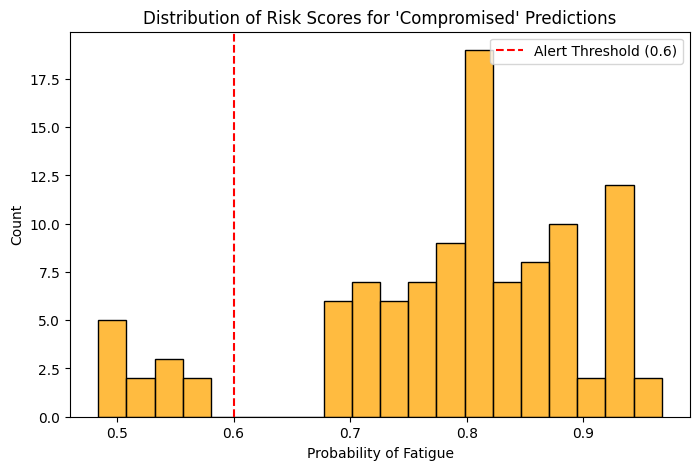

In [168]:
# --- 4. STAGE 2: PROBABILITY-BASED ALERTS ---
# Get the probability that the user is Compromised (Class 1)
y_prob_compromised = best_rf.predict_proba(X_test)[:, 1]

# Define Alert Logic
# If Prob > 0.70 --> High Confidence --> "Fatigued" (Red)
# If Prob < 0.70 --> Low Confidence  --> "Groggy" (Yellow)
FATIGUE_CONFIDENCE_THRESHOLD = 0.6

final_alerts = []
risk_scores = []

for pred_class, prob in zip(y_pred_binary, y_prob_compromised):
    if pred_class == 0:
        final_alerts.append("Green: Normal")
        risk_scores.append(0)  # Logic: 0 risk
    else:
        # It is Compromised (Class 1). Check severity.
        if prob >= FATIGUE_CONFIDENCE_THRESHOLD:
            final_alerts.append(f"RED: FATIGUE (Risk: {prob:.2f})")
            risk_scores.append(2)
        else:
            final_alerts.append(f"Yellow: Groggy (Risk: {prob:.2f})")
            risk_scores.append(1)

# Display a sample of the results
results_df = pd.DataFrame(
    {
        "Actual_Binary": y_test.values,
        "Predicted_Binary": y_pred_binary,
        "Risk_Probability": y_prob_compromised,
        "Final_Alert": final_alerts,
    }
)

print("\n--- SAMPLE ALERTS (Stage 2 Output) ---")
print(results_df.sample(10))

# Optional: Visualize the Split
plt.figure(figsize=(8, 5))
sns.histplot(
    data=results_df[results_df["Predicted_Binary"] == 1],
    x="Risk_Probability",
    bins=20,
    color="orange",
)
plt.axvline(
    FATIGUE_CONFIDENCE_THRESHOLD,
    color="red",
    linestyle="--",
    label=f"Alert Threshold ({FATIGUE_CONFIDENCE_THRESHOLD})",
)
plt.title("Distribution of Risk Scores for 'Compromised' Predictions")
plt.xlabel("Probability of Fatigue")
plt.legend()
plt.show()

Generating Learning Curve (this may take a moment)...


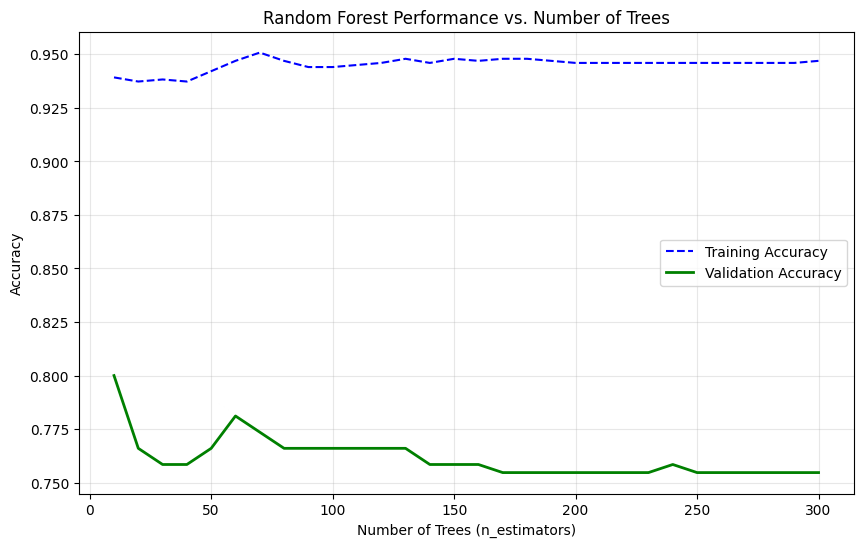

Final Training Accuracy:   94.69%
Final Validation Accuracy: 75.47%
Overfitting Gap:           19.22%


In [169]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- 1. SETUP THE WARM-START MODEL ---
# We retrieve the best parameters from your Grid Search
best_params = grid_search_rf.best_params_

# We set warm_start=True so we can add trees incrementally without retraining
rf_monitor = RandomForestClassifier(**best_params, warm_start=True, random_state=42)

# Reset n_estimators to 0 initially (we will increase it in the loop)
rf_monitor.n_estimators = 0

# --- 2. ITERATE AND TRAIN ---
# Define the range of trees to test (e.g., 1 tree up to 300 trees)
# We step by 10 to make it faster
trees_range = range(10, 310, 10)

train_scores = []
val_scores = []

print("Generating Learning Curve (this may take a moment)...")

for n_trees in trees_range:
    # Update number of trees
    rf_monitor.n_estimators = n_trees

    # Train (because of warm_start, it just adds the new trees)
    rf_monitor.fit(X_train, y_train)

    # Evaluate Training Accuracy
    y_train_pred = rf_monitor.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_scores.append(train_acc)

    # Evaluate Validation Accuracy (using X_test here)
    y_val_pred = rf_monitor.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)
    val_scores.append(val_acc)

# --- 3. PLOT THE RESULTS ---
plt.figure(figsize=(10, 6))
plt.plot(trees_range, train_scores, label="Training Accuracy", color="blue", linestyle="--")
plt.plot(trees_range, val_scores, label="Validation Accuracy", color="green", linewidth=2)

plt.title("Random Forest Performance vs. Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Diagnose the result
gap = train_scores[-1] - val_scores[-1]
print(f"Final Training Accuracy:   {train_scores[-1]:.2%}")
print(f"Final Validation Accuracy: {val_scores[-1]:.2%}")
print(f"Overfitting Gap:           {gap:.2%}")

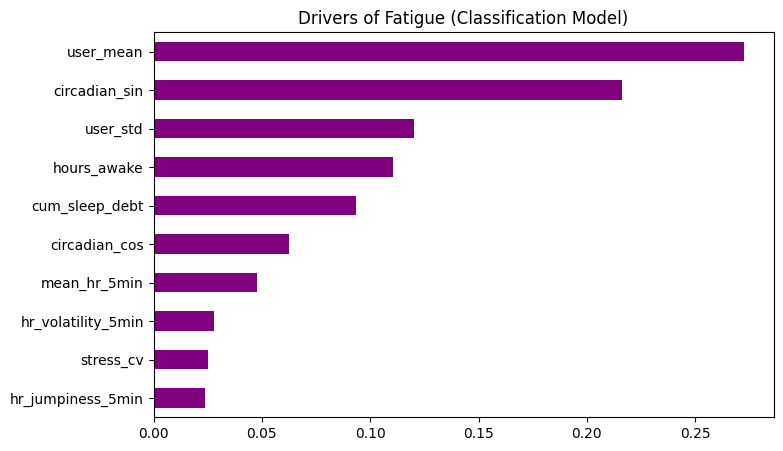

In [170]:
# Check Feature Importance for the Classifier
plt.figure(figsize=(8, 5))
imp = pd.Series(best_rf.feature_importances_, index=features).sort_values()
imp.plot(kind="barh", color="purple")
plt.title("Drivers of Fatigue (Classification Model)")
plt.show()

In [191]:
# --- STEP 1: GET THE USER'S CONTEXT (BASELINE) ---
# We look up User 3369 in your existing training data to find their "Normal"
# (If this returns an error, it means 3369 wasn't in the training set)
user_id = 3369

if user_id in user_profiles:
    context = user_profiles[user_id]
    print(f"User {user_id} Profile Found:")
    print(f" - Baseline Speed (Mean): {context['user_mean']:.2f} ms")
    print(f" - Consistency (Std Dev): {context['user_std']:.2f} ms")
else:
    # Fallback if 3369 is a brand new employee
    context = {"user_mean": 290.0, "user_std": 30.0}
    print(f"User {user_id} is New. Using Global Averages.")


# --- STEP 2: CREATE "NEW" LIVE DATA ---
# This simulates data coming from the sensors RIGHT NOW.
# Let's simulate a "Fatigue Scenario" (High Sleep Debt + Low HRV)
new_data_packet = {
    # Heart Rate Features (Simulating stress/groginess)
    "mean_hr_5min": 550,  # Slightly elevated
    "hr_volatility_5min": 0.0001,  # Low volatility (often signs of fatigue/stress)
    "hr_jumpiness_5min": 0.005,
    "stress_cv": 0.02,
    # Sleep Features (The big drivers)
    "hours_awake": 22,  # Been awake a long time
    "cum_sleep_debt": 12,  # Missed 4.5 hours of sleep recently (High!)
    "circadian_sin": -0.866,  # Late at night/early morning
    "circadian_cos": 0.5,
}


# --- STEP 3: PREDICT PROBABILITY ---
# We combine the "Context" + "Live Data" into a single row
input_vector = pd.DataFrame(
    [
        {
            "mean_hr_5min": new_data_packet["mean_hr_5min"],
            "hr_volatility_5min": new_data_packet["hr_volatility_5min"],
            "hr_jumpiness_5min": new_data_packet["hr_jumpiness_5min"],
            "stress_cv": new_data_packet["stress_cv"],
            "hours_awake": new_data_packet["hours_awake"],
            "cum_sleep_debt": new_data_packet["cum_sleep_debt"],
            "circadian_sin": new_data_packet["circadian_sin"],
            "circadian_cos": new_data_packet["circadian_cos"],
            "user_mean": context["user_mean"],  # <--- The Personalization
            "user_std": context["user_std"],
        }
    ]
)

# Get the Risk Score (0.0 to 1.0)
risk_probability = best_rf.predict_proba(input_vector)[:, 1][0]

print(f"\nCalculated Risk Score: {risk_probability:.4f} ({risk_probability * 100:.1f}%)")


# --- STEP 4: DECIDE (THE TRAFFIC LIGHT) ---
# Using the thresholds we validated from your histogram:
# Green: < 0.40 | Yellow: 0.40 - 0.65 | Red: > 0.65

if risk_probability < 0.25:
    status = "🟢 GREEN (SAFE)"
    action = "No Action Needed."
elif risk_probability < 0.5:
    status = "🟡 YELLOW (WARNING)"
    action = "Notify User: 'Take a short break or stretch.'"
else:
    status = "🔴 RED (CRITICAL FATIGUE)"
    action = "ALERT: Stop Task Immediately. Intervention Required."

print(f"Decision: {status}")
print(f"Action: {action}")

User 3369 Profile Found:
 - Baseline Speed (Mean): 312.89 ms
 - Consistency (Std Dev): 37.50 ms

Calculated Risk Score: 0.2916 (29.2%)
Decision: 🟡 YELLOW (WARNING)
Action: Notify User: 'Take a short break or stretch.'


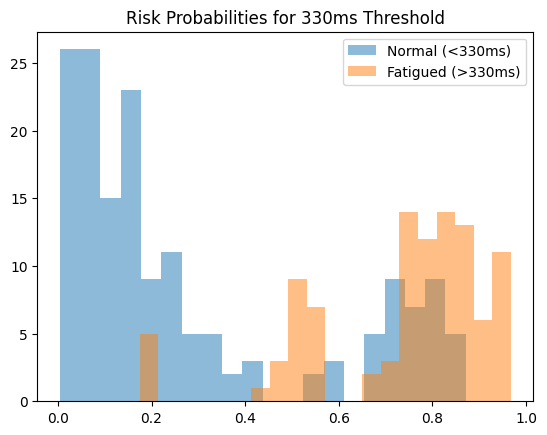

In [172]:
import matplotlib.pyplot as plt

probs = best_rf.predict_proba(X_test)[:, 1]
plt.hist(probs[y_test == 0], bins=20, alpha=0.5, label="Normal (<330ms)")
plt.hist(probs[y_test == 1], bins=20, alpha=0.5, label="Fatigued (>330ms)")
plt.legend()
plt.title("Risk Probabilities for 330ms Threshold")
plt.show()

APPLY THE PERSONALIZED RULE for labeling

In [182]:
import pandas as pd

# 1. Load Data
df = pd.read_csv("./cleaned_data/training_data_all_users.csv")

# 2. Calculate User Context (The "Personal Baseline")
# We need to know what "Normal" looks like for each user first.
user_stats = df.groupby("user_id")["pvt_mean_rt"].agg(["mean", "std"]).reset_index()
user_stats.rename(columns={"mean": "user_mean", "std": "user_std"}, inplace=True)

# Merge these stats back into the main dataframe so every row knows its user's baseline
df = df.merge(user_stats, on="user_id", how="left")
df["user_std"] = df["user_std"].fillna(0)  # Handle single-record users


# 3. APPLY THE PERSONALIZED RULE (The Critical Step)
def create_personalized_target(row):
    # DYNAMIC THRESHOLD:
    # Instead of 290ms, we check: Is this specific test worse than (Mean + 1.5 Std)?
    personal_threshold = row["user_mean"] + (0.3 * row["user_std"])

    if row["pvt_mean_rt"] > personal_threshold:
        return 1  # Label: COMPROMISED (Fatigued relative to self)
    else:
        return 0  # Label: NORMAL (Safe relative to self)


# Create the new Target Column
df["fatigue_binary"] = df.apply(create_personalized_target, axis=1)

# 4. SET UP TRAINING
# NOW you proceed to split X and y.
# The model will try to predict this new 'fatigue_binary' column.
features = [
    "mean_hr_5min",
    "hr_volatility_5min",
    "hr_jumpiness_5min",
    "stress_cv",
    "hours_awake",
    "cum_sleep_debt",
    "circadian_sin",
    "circadian_cos",
    "user_mean",
    "user_std",
]

X = df[features]
y = df["fatigue_binary"]

groups = df["user_id"].astype(str) + "_" + df["TESTSTART"].astype(str)

# Check imbalance (You likely have way more Class 1 than Class 2)
print("Class Counts:\n", y.value_counts())

Class Counts:
 fatigue_binary
0    972
1    329
Name: count, dtype: int64


Training on 1036 samples. Testing on 265 samples.

TRAINING RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF Params: {'bootstrap': True, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}


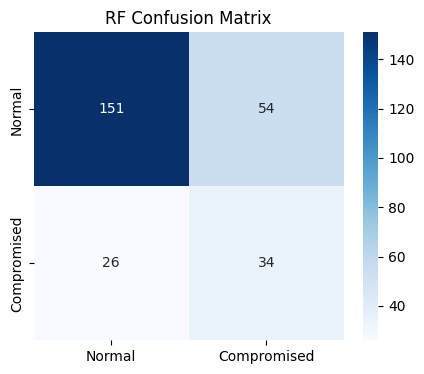

              precision    recall  f1-score   support

      Normal       0.85      0.74      0.79       205
 Compromised       0.39      0.57      0.46        60

    accuracy                           0.70       265
   macro avg       0.62      0.65      0.63       265
weighted avg       0.75      0.70      0.72       265



In [183]:
from sklearn.ensemble import RandomForestClassifier

# ==============================================================================
# OPTION B: RANDOM FOREST (RF)
# ==============================================================================

# --- 2. TRAIN BINARY MODEL ---
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter_test.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

print(f"Training on {len(X_train)} samples. Testing on {len(X_test)} samples.")


print("\n" + "=" * 40)
print("TRAINING RANDOM FOREST")
print("=" * 40)

# Random Forest Hyperparameters
rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [7, 10, 12],  # RF can handle deeper trees
    "min_samples_split": [10, 15, 20, 25],  # Controls overfitting
    "min_samples_leaf": [2, 4, 8],  # Controls noise sensitivity
    "max_features": ["sqrt"],  # Number of features per tree
    "bootstrap": [True],
}

# Note: class_weight='balanced' helps RF handle imbalanced data automatically
rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 5})

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    cv=gkf,
    scoring="recall",
    n_jobs=-1,
    verbose=1,
)

grid_search_rf.fit(X_train, y_train, groups=groups_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best RF Params: {grid_search_rf.best_params_}")

y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Compromised"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("RF Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

Generating Learning Curve (this may take a moment)...


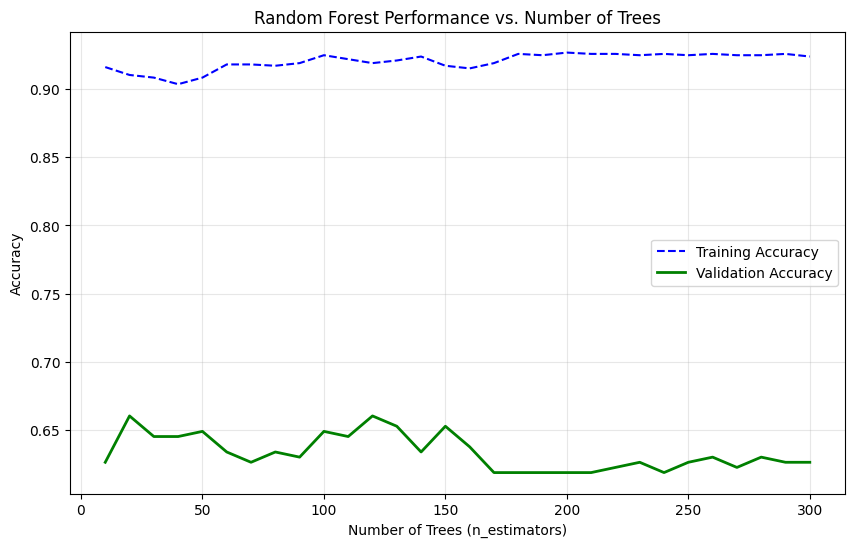

Final Training Accuracy:   92.37%
Final Validation Accuracy: 62.64%
Overfitting Gap:           29.73%


In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- 1. SETUP THE WARM-START MODEL ---
# We retrieve the best parameters from your Grid Search
best_params = grid_search_rf.best_params_

# We set warm_start=True so we can add trees incrementally without retraining
rf_monitor = RandomForestClassifier(**best_params, warm_start=True, random_state=42)

# Reset n_estimators to 0 initially (we will increase it in the loop)
rf_monitor.n_estimators = 0

# --- 2. ITERATE AND TRAIN ---
# Define the range of trees to test (e.g., 1 tree up to 300 trees)
# We step by 10 to make it faster
trees_range = range(10, 310, 10)

train_scores = []
val_scores = []

print("Generating Learning Curve (this may take a moment)...")

for n_trees in trees_range:
    # Update number of trees
    rf_monitor.n_estimators = n_trees

    # Train (because of warm_start, it just adds the new trees)
    rf_monitor.fit(X_train, y_train)

    # Evaluate Training Accuracy
    y_train_pred = rf_monitor.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_scores.append(train_acc)

    # Evaluate Validation Accuracy (using X_test here)
    y_val_pred = rf_monitor.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)
    val_scores.append(val_acc)

# --- 3. PLOT THE RESULTS ---
plt.figure(figsize=(10, 6))
plt.plot(trees_range, train_scores, label="Training Accuracy", color="blue", linestyle="--")
plt.plot(trees_range, val_scores, label="Validation Accuracy", color="green", linewidth=2)

plt.title("Random Forest Performance vs. Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Diagnose the result
gap = train_scores[-1] - val_scores[-1]
print(f"Final Training Accuracy:   {train_scores[-1]:.2%}")
print(f"Final Validation Accuracy: {val_scores[-1]:.2%}")
print(f"Overfitting Gap:           {gap:.2%}")

--- EVALUATION AT THRESHOLD 0.25 ---
              precision    recall  f1-score   support

      Normal       0.84      0.16      0.26       205
 Compromised       0.24      0.90      0.38        60

    accuracy                           0.32       265
   macro avg       0.54      0.53      0.32       265
weighted avg       0.71      0.32      0.29       265



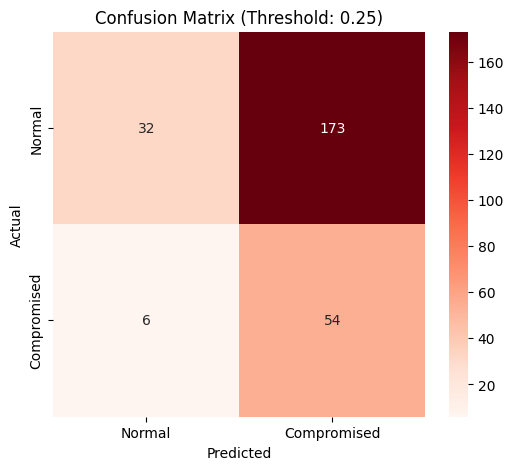

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get the probabilities from your current model
y_probs = best_rf.predict_proba(X_test)[:, 1]

# 2. Apply your calculated threshold (0.1680)
# This says: "Anyone with risk > 16.8% is flagged as Compromised"
CUSTOM_THRESHOLD = 0.25
y_pred_custom = (y_probs >= CUSTOM_THRESHOLD).astype(int)

# 3. Check the results
print(f"--- EVALUATION AT THRESHOLD {CUSTOM_THRESHOLD} ---")
print(classification_report(y_test, y_pred_custom, target_names=["Normal", "Compromised"]))

# 4. Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Normal", "Compromised"],
    yticklabels=["Normal", "Compromised"],
)
plt.title(f"Confusion Matrix (Threshold: {CUSTOM_THRESHOLD})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [190]:
# --- STEP 1: GET THE USER'S CONTEXT (BASELINE) ---
# We look up User 3369 in your existing training data to find their "Normal"
# (If this returns an error, it means 3369 wasn't in the training set)
# --- STEP 1: DEFINE YOUR OPTIMIZED THRESHOLDS ---
# Based on your previous analysis where 0.168 gave 80% Recall
THRESHOLD_WARNING = 0.25  # Yellow starts here
THRESHOLD_CRITICAL = 0.35  # Red starts here (approx. top 5% of risk)

user_id = 3369

if user_id in user_profiles:
    context = user_profiles[user_id]
    print(f"User {user_id} Profile Found:")
    print(f" - Baseline Speed (Mean): {context['user_mean']:.2f} ms")
    print(f" - Consistency (Std Dev): {context['user_std']:.2f} ms")
else:
    # Fallback if 3369 is a brand new employee
    context = {"user_mean": 290.0, "user_std": 30.0}
    print(f"User {user_id} is New. Using Global Averages.")


# --- STEP 2: CREATE "NEW" LIVE DATA ---
# This simulates data coming from the sensors RIGHT NOW.
# Let's simulate a "Fatigue Scenario" (High Sleep Debt + Low HRV)
new_data_packet = {
    # Heart Rate Features (Simulating stress/groginess)
    "mean_hr_5min": 550,  # Slightly elevated
    "hr_volatility_5min": 0.0001,  # Low volatility (often signs of fatigue/stress)
    "hr_jumpiness_5min": 0.005,
    "stress_cv": 0.02,
    # Sleep Features (The big drivers)
    "hours_awake": 22,  # Been awake a long time
    "cum_sleep_debt": 12,  # Missed 4.5 hours of sleep recently (High!)
    "circadian_sin": -0.866,  # Late at night/early morning
    "circadian_cos": 0.5,
}


# --- STEP 3: PREDICT PROBABILITY ---
# We combine the "Context" + "Live Data" into a single row
input_vector = pd.DataFrame(
    [
        {
            "mean_hr_5min": new_data_packet["mean_hr_5min"],
            "hr_volatility_5min": new_data_packet["hr_volatility_5min"],
            "hr_jumpiness_5min": new_data_packet["hr_jumpiness_5min"],
            "stress_cv": new_data_packet["stress_cv"],
            "hours_awake": new_data_packet["hours_awake"],
            "cum_sleep_debt": new_data_packet["cum_sleep_debt"],
            "circadian_sin": new_data_packet["circadian_sin"],
            "circadian_cos": new_data_packet["circadian_cos"],
            "user_mean": context["user_mean"],  # <--- The Personalization
            "user_std": context["user_std"],
        }
    ]
)

# Get the Risk Score (0.0 to 1.0)
risk_probability = best_rf.predict_proba(input_vector)[:, 1][0]

print(f"\nCalculated Risk Score: {risk_probability:.4f} ({risk_probability * 100:.1f}%)")


# --- STEP 4: DECIDE (THE TRAFFIC LIGHT) ---
# Using the thresholds we validated from your histogram:
# Green: < 0.40 | Yellow: 0.40 - 0.65 | Red: > 0.65

if risk_probability < THRESHOLD_WARNING:
    status = "🟢 GREEN (SAFE)"
    action = "No Action Needed."
elif risk_probability < THRESHOLD_CRITICAL:
    status = "🟡 YELLOW (WARNING)"
    action = "Notify User: 'Take a short break or stretch.'"
else:
    status = "🔴 RED (CRITICAL FATIGUE)"
    action = "ALERT: Stop Task Immediately. Intervention Required."

print(f"Decision: {status}")
print(f"Action: {action}")

User 3369 Profile Found:
 - Baseline Speed (Mean): 312.89 ms
 - Consistency (Std Dev): 37.50 ms

Calculated Risk Score: 0.2916 (29.2%)
Decision: 🟡 YELLOW (WARNING)
Action: Notify User: 'Take a short break or stretch.'
